# Compare resnet50 tensorflow
This jupyter is for speed comparison of the tensorflow and tf-trt models. 

# Check server and library: Ubuntu and cuda version

In [1]:
! cat /etc/issue
! cat /usr/local/cuda/version.txt
! uname -a

Ubuntu 18.04.5 LTS \n \l

CUDA Version 11.0.228
Linux d7d94d2f0dd2 4.19.112+ #1 SMP Thu Jul 23 08:00:38 PDT 2020 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
# check availbility of TensorRT
! dpkg -l | grep TensorRT

In [3]:
# check tensorflow version
import tensorflow as tf
tf.__version__

'2.4.1'

In [4]:
# check tensor core gpu
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True

print("Tensor Core GPU Present:", check_tensor_core_gpu_present())

Tensor Core GPU Present: True


# Import related modules

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Prepare images for testing

## Download images

In [6]:
num_images = 20

In [7]:
!mkdir ./data
!wget  -O ./data/img0.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Siam_lilacpoint.jpg/440px-Siam_lilacpoint.jpg"
!wget  -O ./data/img1.jpg "https://media.wired.com/photos/5bb532b7f8a2e62d0bd5c4e3/master/w_2560%2Cc_limit/bee-146810332.jpg"
!wget  -O ./data/img2.jpg "https://image-cdn.hypb.st/https%3A%2F%2Fhypebeast.com%2Fimage%2F2020%2F05%2Fnba-drops-spalding-basketball-for-wilson-2021-season-1.jpg?q=90&w=1400&cbr=1&fit=max"
!wget  -O ./data/img3.jpg "http://www.kamogawa-seaworld.jp/aquarium/aquarium_info/images/kurage201908/ph01.jpg"
!wget  -O ./data/img4.jpg "https://files.nccih.nih.gov/horse-chestnut-aesculus-hippocastanum-gettyimages-95791857-square.jpg"

!wget  -O ./data/img5.jpg "https://zukan.pokemon.co.jp/zukan-api/up/images/index/0307cb5bf57607937c2112f9791eb7dd.png"
!wget  -O ./data/img6.jpg "https://zukan.pokemon.co.jp/zukan-api/up/images/index/481d67bad0e4899717bb69f08b4c1a94.png"
!wget  -O ./data/img7.jpg "https://img.gamewith.jp/article/thumbnail/rectangle/25235.png?date=1555917396"
!wget  -O ./data/img8.jpg "https://zukan.pokemon.co.jp/zukan-api/up/images/index/39e9311c11f99b98d9a8c3f8389470fc.png"
!wget  -O ./data/img9.jpg "https://zukan.pokemon.co.jp/zukan-api/up/images/index/e4ff08120b4329ddef9896c4b44a6cf0.png"

mkdir: cannot create directory ‘./data’: File exists
--2021-03-28 04:45:12--  https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Siam_lilacpoint.jpg/440px-Siam_lilacpoint.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45389 (44K) [image/jpeg]
Saving to: ‘./data/img0.jpg’

./data/img0.jpg     100%[===================>]  44.33K  --.-KB/s    in 0.03s   

2021-03-28 04:45:12 (1.44 MB/s) - ‘./data/img0.jpg’ saved [45389/45389]

--2021-03-28 04:45:12--  https://media.wired.com/photos/5bb532b7f8a2e62d0bd5c4e3/master/w_2560%2Cc_limit/bee-146810332.jpg
Resolving media.wired.com (media.wired.com)... 151.101.0.239, 151.101.64.239, 151.101.128.239, ...
Connecting to media.wired.com (media.wired.com)|151.101.0.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308828 (302K

## Check images

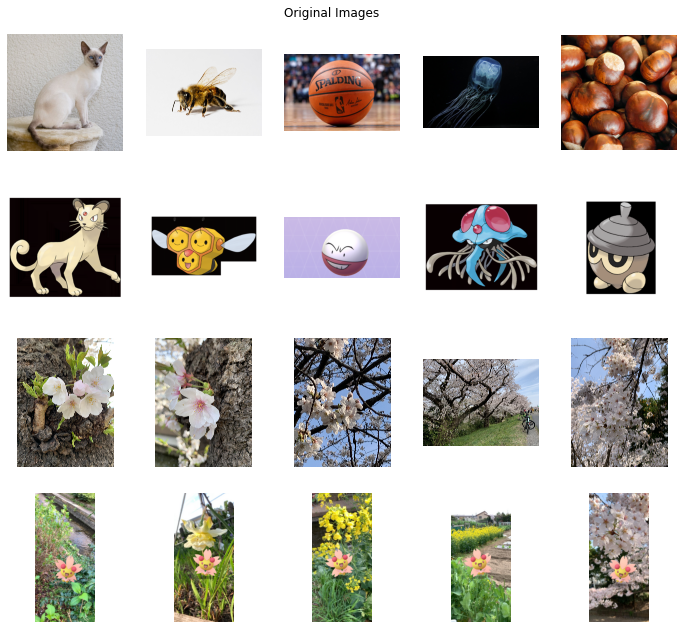

In [8]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(figsize=(12,10), nrows=4, ncols=int(num_images/4))    
for i in range(num_images):
    img_path = './data/img%d.jpg'%i
    img = image.load_img(img_path)
    plt.subplot(4,num_images/4,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Original Images")
plt.subplots_adjust(top=0.95)

# Load and save pretained model

In [9]:
# load pretrained model
model = ResNet50(weights='imagenet')
# imagenet label: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

# save model
model.save('resnet50_model_tf') 

# show model details
# !saved_model_cli show --all --dir resnet50_model_tf

INFO:tensorflow:Assets written to: resnet50_model_tf/assets


# Performance testing

## Tensorflow (benchmark)

In [10]:
# load model
def load_tensorflow_saved_model(model_name):
    resnet50_model = tf.saved_model.load('resnet50_model_tf', tags=[tf.saved_model.SERVING])
    return resnet50_model
resnet50_model = load_tensorflow_saved_model('resnet50_model_tf')

In [11]:
def process_images(img_path, infer_flag=None):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x) if infer_flag is not None else x
    pil_img = image.array_to_img(x[0])
    return pil_img, x

In [12]:
# predict images using the model
def predict_images(model, num_images, infer_flag=None):
    fig, axes = plt.subplots(figsize=(12,10), nrows=4, ncols=int(num_images/4))
    time_list = []
    for i in range(num_images):
        img_path = './data/img%d.jpg'%i
        if not os.path.exists(img_path):
            img_path = './data/img%d.jpg'%(i-10)
        # process images
        input_img, x = process_images(img_path, infer_flag)

        # start timing
        start_time = time.time()
        if infer_flag is None:
            preds = model.predict(x)
        else:
            labeling = model(x)
            preds = labeling['predictions'].numpy()
        end_time = time.time()
        # end timing

        # calculate inference time
        inference_time = ( end_time - start_time ) * 1000

        # decode the results into a list of tuples (class, description, probability)
        decoded_result = decode_predictions(preds, top=3)[0]

        # print out the result
        print('Image {}: {:4.1f}ms => {}'.format(i, inference_time, decoded_result))
        time_list.append(inference_time)
        plt.subplot(4,num_images/4,i+1)
        plt.imshow(input_img);
        plt.axis('off');
        plt.title(decoded_result[0][1])
    plt.suptitle("Tensorflow preprocessed images")
    plt.subplots_adjust(top=0.90)
    # plt.tight_layout()
    print ("median time: {} ms".format(np.median(time_list)))
    return 

Image 0: 3743.3ms => [('n02123597', 'Siamese_cat', 0.996485), ('n02124075', 'Egyptian_cat', 0.0022793661), ('n02085620', 'Chihuahua', 0.0007795812)]
Image 1: 45.8ms => [('n02206856', 'bee', 0.86296016), ('n02190166', 'fly', 0.020439807), ('n02264363', 'lacewing', 0.010499455)]
Image 2: 42.2ms => [('n02802426', 'basketball', 1.0), ('n04118538', 'rugby_ball', 1.3029867e-09), ('n04023962', 'punching_bag', 3.1101913e-10)]
Image 3: 38.0ms => [('n01910747', 'jellyfish', 0.9998443), ('n03876231', 'paintbrush', 7.9724035e-05), ('n04275548', 'spider_web', 3.1165022e-05)]
Image 4: 37.6ms => [('n12768682', 'buckeye', 0.9971841), ('n12267677', 'acorn', 0.0023393256), ('n03461385', 'grocery_store', 0.0003031647)]
Image 5: 39.1ms => [('n02109047', 'Great_Dane', 0.22894286), ('n02110341', 'dalmatian', 0.178073), ('n06359193', 'web_site', 0.12062577)]
Image 6: 37.4ms => [('n06359193', 'web_site', 0.398075), ('n03291819', 'envelope', 0.14218351), ('n03595614', 'jersey', 0.03926747)]
Image 7: 43.0ms => 

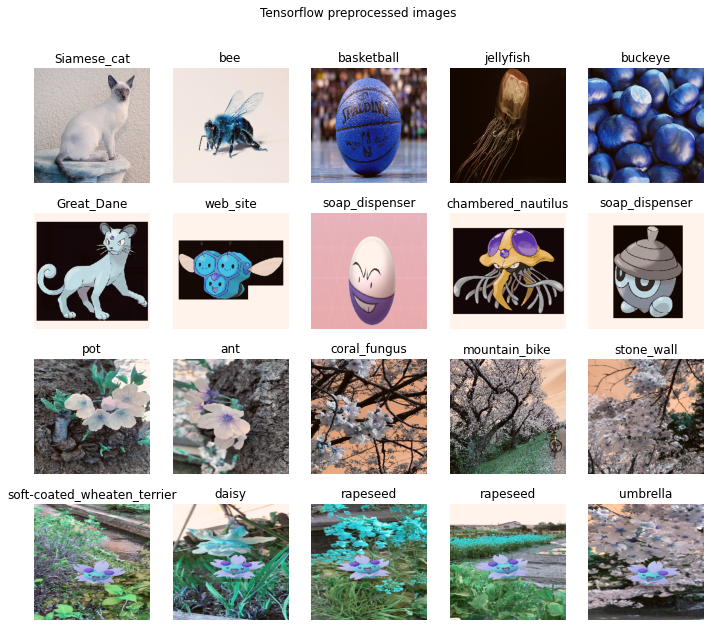

In [13]:
predict_images(model, num_images)

## Convert tensorflow to tensorrt model

In [14]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
def convert_model_from_tensorflow_to_tensorrt(convert_case, input_model_name, output_model_name):
    # set up conversion parameters
    if convert_case == 'FP32':
        conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
            precision_mode=trt.TrtPrecisionMode.FP32,
            max_workspace_size_bytes=(1<<32))
    elif convert_case == 'FP16':
        conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
            precision_mode=trt.TrtPrecisionMode.FP16,
            max_workspace_size_bytes=(1<<32))
    elif convert_case == 'INT8':
        conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
            precision_mode=trt.TrtPrecisionMode.INT8, 
            max_workspace_size_bytes=(1<<32), 
            use_calibration=True)

    # convert model to tensorrt (float32 or float16 or int8)
    converter = trt.TrtGraphConverterV2(input_saved_model_dir=input_model_name,
                                        conversion_params=conversion_params)
    if convert_case == 'FP32' or convert_case == 'FP16':
        converter.convert()
    elif convert_case == 'INT8': # calibration is needed for int8 case
        batch_size = 1
        def calibration_input_fn():
            yield (np.random.uniform(size=(batch_size, 224, 224, 3)).astype(np.float32), )
        converter.convert(calibration_input_fn=calibration_input_fn)


    # save the converted model
    converter.save(output_saved_model_dir=output_model_name)

    return 

In [15]:
def load_tensorrt_model(model_name):
    # load saved model
    saved_model_loaded = tf.saved_model.load(model_name, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)    
    return infer

### TF-TRT FP32

In [16]:
convert_model_from_tensorflow_to_tensorrt('FP32','resnet50_model_tf', 'resnet50_model_TFTRT_FP32')
# show model detail
# !saved_model_cli show --all --dir resnet50_model_TFTRT_FP32

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: resnet50_model_TFTRT_FP32/assets


['serving_default']
{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}
Image 0: 2572.9ms => [('n02123597', 'Siamese_cat', 0.996485), ('n02124075', 'Egyptian_cat', 0.0022793773), ('n02085620', 'Chihuahua', 0.00077958265)]
Image 1: 13.1ms => [('n02206856', 'bee', 0.86296016), ('n02190166', 'fly', 0.020439789), ('n02264363', 'lacewing', 0.010499465)]
Image 2: 12.7ms => [('n02802426', 'basketball', 1.0), ('n04118538', 'rugby_ball', 1.3029893e-09), ('n04023962', 'punching_bag', 3.1101913e-10)]
Image 3: 12.7ms => [('n01910747', 'jellyfish', 0.9998443), ('n03876231', 'paintbrush', 7.9724115e-05), ('n04275548', 'spider_web', 3.116511e-05)]
Image 4: 12.7ms => [('n12768682', 'buckeye', 0.9971841), ('n12267677', 'acorn', 0.0023393345), ('n03461385', 'grocery_store', 0.0003031653)]
Image 5: 12.8ms => [('n02109047', 'Great_Dane', 0.22894308), ('n02110341', 'dalmatian', 0.17807299), ('n06359193', 'web_site', 0.12062566)]
Image 6: 12.8ms => [('n06359193', 'web_site'

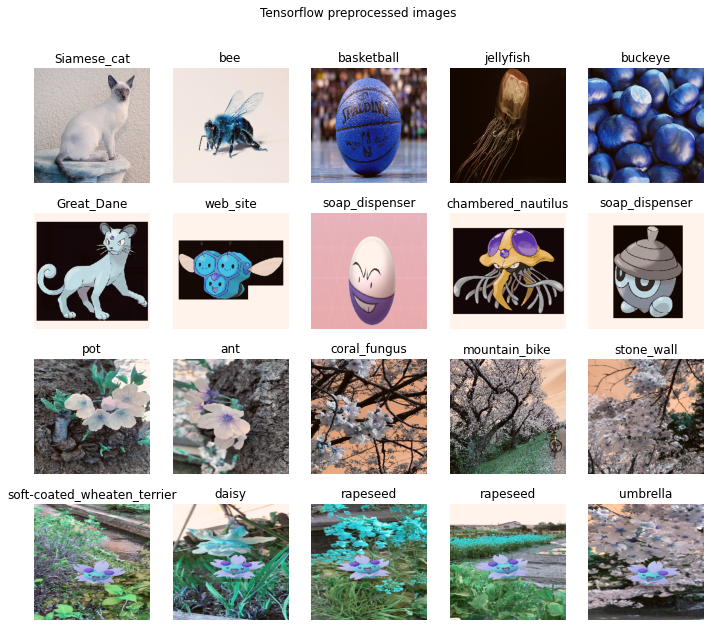

In [17]:
# load tensorrt model
infer_fp32 = load_tensorrt_model("resnet50_model_TFTRT_FP32")

# use tensorrt model for predict image
predict_images(infer_fp32, num_images, "infer_fp32")

### TF-TRT FP16

In [18]:
convert_model_from_tensorflow_to_tensorrt('FP16','resnet50_model_tf', 'resnet50_model_TFTRT_FP16')
# show model detail
# !saved_model_cli show --all --dir resnet50_model_TFTRT_FP32

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: resnet50_model_TFTRT_FP16/assets


['serving_default']
{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}
Image 0: 13.3ms => [('n02123597', 'Siamese_cat', 0.996485), ('n02124075', 'Egyptian_cat', 0.0022793773), ('n02085620', 'Chihuahua', 0.00077958265)]
Image 1: 13.0ms => [('n02206856', 'bee', 0.86296016), ('n02190166', 'fly', 0.020439789), ('n02264363', 'lacewing', 0.010499465)]
Image 2: 13.0ms => [('n02802426', 'basketball', 1.0), ('n04118538', 'rugby_ball', 1.3029893e-09), ('n04023962', 'punching_bag', 3.1101913e-10)]
Image 3: 13.2ms => [('n01910747', 'jellyfish', 0.9998443), ('n03876231', 'paintbrush', 7.9724115e-05), ('n04275548', 'spider_web', 3.116511e-05)]
Image 4: 12.9ms => [('n12768682', 'buckeye', 0.9971841), ('n12267677', 'acorn', 0.0023393345), ('n03461385', 'grocery_store', 0.0003031653)]
Image 5: 13.1ms => [('n02109047', 'Great_Dane', 0.22894308), ('n02110341', 'dalmatian', 0.17807299), ('n06359193', 'web_site', 0.12062566)]
Image 6: 12.8ms => [('n06359193', 'web_site', 

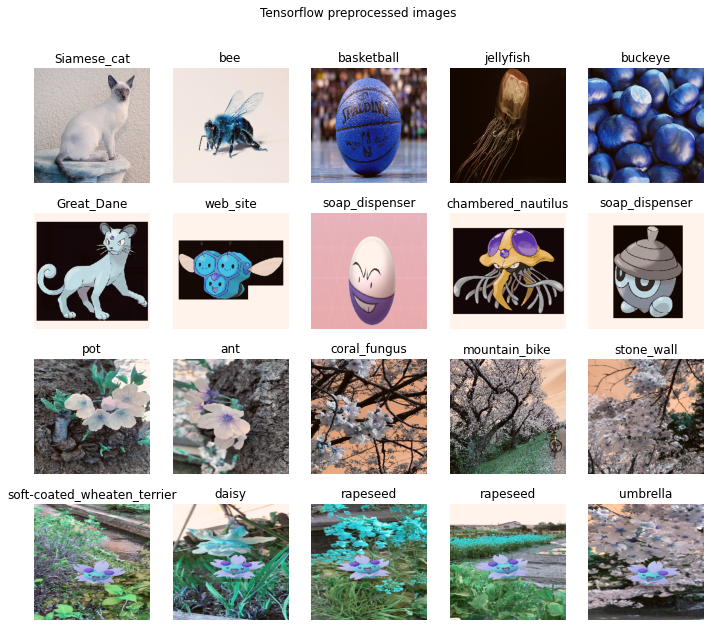

In [19]:
# load tensorrt model
infer_fp16 = load_tensorrt_model("resnet50_model_TFTRT_FP16")

# use tensorrt model for predict image
predict_images(infer_fp32, num_images, "infer_fp16")

### TF-TRT INT8

In [20]:
convert_model_from_tensorflow_to_tensorrt('INT8','resnet50_model_tf', 'resnet50_model_TFTRT_INT8')
# show model detail
# !saved_model_cli show --all --dir resnet50_model_TFTRT_INT8

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: resnet50_model_TFTRT_INT8/assets


['serving_default']
{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}
Image 0: 2639.6ms => [('n02123597', 'Siamese_cat', 0.996485), ('n02124075', 'Egyptian_cat', 0.0022793773), ('n02085620', 'Chihuahua', 0.00077958265)]
Image 1: 12.8ms => [('n02206856', 'bee', 0.86296016), ('n02190166', 'fly', 0.020439789), ('n02264363', 'lacewing', 0.010499465)]
Image 2: 12.8ms => [('n02802426', 'basketball', 1.0), ('n04118538', 'rugby_ball', 1.3029893e-09), ('n04023962', 'punching_bag', 3.1101913e-10)]
Image 3: 12.8ms => [('n01910747', 'jellyfish', 0.9998443), ('n03876231', 'paintbrush', 7.9724115e-05), ('n04275548', 'spider_web', 3.116511e-05)]
Image 4: 12.5ms => [('n12768682', 'buckeye', 0.9971841), ('n12267677', 'acorn', 0.0023393345), ('n03461385', 'grocery_store', 0.0003031653)]
Image 5: 14.9ms => [('n02109047', 'Great_Dane', 0.22894308), ('n02110341', 'dalmatian', 0.17807299), ('n06359193', 'web_site', 0.12062566)]
Image 6: 13.1ms => [('n06359193', 'web_site'

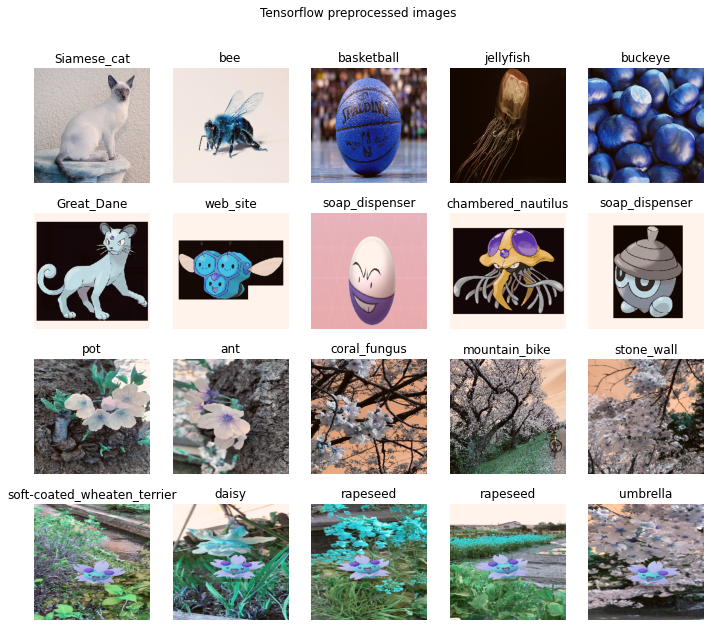

In [21]:
# load tensorrt model
infer_int8 = load_tensorrt_model("resnet50_model_TFTRT_INT8")

# use tensorrt model for predict image
predict_images(infer_int8, num_images, "infer_int8")

# convert tensorflow model to ONNX format

In [22]:
# ! pip3 install -U tf2onnx

In [23]:
import onnx
import tf2onnx
img0, x = process_images('./data/img0.jpg')
model_proto, external_tensor_storage = tf2onnx.convert.from_keras(model, input_signature=[tf.TensorSpec(shape=x.shape, dtype=tf.float32)])
onnx.save(model_proto,'./resnet50_model_tf/resnet50_tf_onnx.onnx"')
# ! python3 -m tf2onnx.convert --saved-model "./resnet50_model_tf" --output "./resnet50_model_tf/resnet50_tf_onnx.onnx"

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


# Write graph to tensorboard

In [24]:
def write_graph_to_tensorboard(model, logname, infer_flag=False):
    log_dir = "runs/" + logname #+ "img0"
    if os.path.exists(log_dir):
        ! rm -r $log_dir

    img_path = './data/img0.jpg'
    input_img, input_data = process_images(img_path)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir, update_freq=1)
    if infer_flag is False:
        preds = model.predict(input_data, callbacks=[tb_callback])
    else:
        # #### still WIP
        labeling = model(input_data)
        preds = labeling['predictions'].numpy()
    writer = tf.summary.create_file_writer(log_dir)
    with writer.as_default():
        tf.summary.image("Test image0", input_data, step=0)
    return

In [25]:
write_graph_to_tensorboard(model, "resnet50_model_tf")

In [26]:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir="runs"

Reusing TensorBoard on port 6006 (pid 1197), started 1:02:30 ago. (Use '!kill 1197' to kill it.)

<IPython.core.display.Javascript object>

In [27]:
#### still WIP
# log_dir = 'runs/resnet50_int8'
# img_path = './data/img0.jpg'
# input_img, input_data = process_images(img_path, "infer_int8")

# @tf.function
# def pred_func(model, input_data):
#     # infer model
#     print ("infer_int8", model)
#     # tb_callback2 = tf.keras.callbacks.TensorBoard(log_dir, update_freq=1)
#     labeling = model(input_data)
#     preds = labeling['predictions']#.numpy()
#     print ("preds", preds)
#     return preds

# writer = tf.summary.create_file_writer(log_dir)
# tf.summary.trace_on(graph=True, profiler=True)
# preds = pred_func(infer_int8, input_data)

# with writer.as_default():
#     tf.summary.image("Test image0", input_data, step=0)
#     tf.summary.trace_export(name="infer_func", step=0, profiler_outdir=log_dir)